# Benchmark Statistics

In this notebook, we assess the evaluated benchmarks in terms of the length, average PMI diff, average Max Gender PMI diff in each sentence, number of gendered words, template length and position of the pronouns. 

In [2]:
import pathlib as pl

import glob
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style("whitegrid")
sns.set_palette(sns.color_palette("colorblind"))

import itertools, warnings

from collections import Counter, defaultdict
from typing import List, Dict, Tuple

# -------------------------------------------------------------------
# Utility constants used across evaluation notebooks
from utils import GROUP_PAIRED_WORDLIST, FEMALE_WORDS, MALE_WORDS
# Utility methods used across evaluation notebooks
from utils import get_model_size, canonic_model_name

##### Load the word-level PMI 

The word-level PMI was pre computed from PILE it is computed based on the counts made available by [Razeghi et al. 2022](https://aclanthology.org/2022.emnlp-demos.39/).
The file consists of precomputed pointwise mutual information (PMI) values for each word (row) and specific gendered words (as indicated in the column names, e.g., "pmi_her" defines the PMI value between every word and the word "her").

In [3]:
BASE_DIR = "/extra/ucinlp1/cbelem/projects/bias-diagnosis"

# loads the PMI information precomputed based on the PILE co-occurrence counts
GENDER_PMI = pd.read_csv(f"{BASE_DIR}/word2gender_pmi_PILE.csv", index_col=0)
print("Length:", len(GENDER_PMI))
GENDER_PMI.describe()

Length: 152515


,pmi__her,pmi__his,pmi__him,pmi__hers,pmi__mother,pmi__father,pmi__mom,pmi__dad,pmi__mummy,pmi__daddy,...,pmi__queen,pmi__king,pmi__queens,pmi__kings,pmi__princess,pmi__prince,pmi__princesses,pmi__princes,pmi__he,pmi__she
count,80439.000000,98771.000000,65608.000000,7537.000000,30706.000000,29684.000000,10998.000000,10495.000000,1717.000000,2977.000000,...,10119.000000,19446.000000,3313.000000,6617.000000,5412.000000,8203.000000,1266.000000,3825.000000,100828.000000,66891.000000
mean,-24.827642,-24.861843,-24.803681,-24.205257,-24.915487,-24.912725,-25.195694,-25.311220,-24.439117,-25.298108,...,-25.361834,-25.395301,-24.835216,-24.729553,-25.019586,-25.328138,-23.698000,-23.932025,-25.416424,-25.262707
std,1.563299,1.580690,1.506580,1.445382,1.324532,1.342077,1.403486,1.310585,1.538892,1.450787,...,1.435780,1.500407,1.723579,1.696653,1.477100,1.462137,1.718849,1.715749,1.514534,1.499545
min,-33.499275,-33.331670,-33.613325,-30.640672,-30.936595,-30.878193,-30.376505,-30.894450,-29.312282,-30.237593,...,-30.485745,-31.237119,-28.636829,-29.793686,-30.302262,-31.337065,-30.067307,-29.995963,-32.885207,-33.474327
25%,-25.685422,-25.682861,-25.638325,-25.184315,-25.755291,-25.742207,-26.175983,-26.204275,-25.419204,-26.245775,...,-26.331394,-26.407824,-25.942235,-25.915272,-26.010199,-26.314027,-24.823475,-25.134534,-26.219694,-26.079852
50%,-24.622905,-24.552552,-24.605622,-24.219955,-24.857188,-24.823301,-25.178166,-25.242244,-24.648881,-25.315466,...,-25.429962,-25.440690,-25.287083,-24.966771,-25.088823,-25.347642,-24.085664,-24.178638,-25.137871,-25.078310
75%,-23.743398,-23.767377,-23.746094,-23.240134,-24.040494,-24.000929,-24.242664,-24.399705,-23.807955,-24.462129,...,-24.524708,-24.469532,-24.229567,-23.792893,-24.122755,-24.380551,-22.893234,-22.914827,-24.351869,-24.212292
max,-20.458226,-20.727246,-19.520618,-18.544282,-18.927156,-19.795987,-17.653614,-18.349328,-16.823430,-15.609870,...,-17.835727,-18.720616,-16.770424,-17.806201,-17.986234,-18.367298,-15.972031,-16.816626,-20.899774,-21.228257


#### PMI difference between gendered words

Compute the PMI difference between col1 and col2.

In [4]:
def get_pmi_diff(
    df: pd.DataFrame, 
    col1: str,
    col2: str,
    clip: int=None,
    missing_val: float=0.0,
    prefix_col: str="pmi__",
) -> pd.DataFrame:
    """Obtains the PMI difference between columns col1 and col2. 
    
    Parameters
    ----------
    df: pandas.DataFrame
    
    col1: str
        The female word to use for computing the PMI. Should be one of the
        available suffixes in the provided dataframe's columns.
    
    col2: str
        The male word to use for computing the PMI. Should be one of the
        available suffixes in the provided dataframe's columns.
        
    clip: int, optional
        Positive integer, specifies the cap. If not specified, the pmi
        difference is only computed for words that co-occur with both
        (col1, col2). If specified, we will fill the PMI value with 0
        (ideally it would be a very negative number). You can tweak
        this value using 'missing_val'.
    
    missing_val: float, default 0
        Default value used to replace values that are clipped.
    
    prefix_col: str
        The prefix anteceding the col1 and col2 in the provided dataframe.
        In our files, we prefixes all columns with gendered lexicons using
        the "pmi__" prefix.
    
    Note
    ----
    To replicate the values of the paper you should pass female lexicon words
    as col1 and male lexicon words as col2.
    """
    assert f"{prefix_col}{col1}" in df.columns, f"column {col1} is undefined in dataframe"
    assert f"{prefix_col}{col2}" in df.columns, f"column {col2} is undefined in dataframe"
    
    if clip is None:
        result = df[["word", f"{prefix_col}{col1}", f"{prefix_col}{col2}"]].dropna()
    else:
        result = df[["word", f"{prefix_col}{col1}", f"{prefix_col}{col2}"]].fillna(missing_val)
        
    print(f"('{col1}', '{col2}') pmi-defined words: {len(result)}")
    result[f"pmi({col1})-pmi({col2})"] = result[f"{prefix_col}{col1}"] - result[f"{prefix_col}{col2}"]
    
    if clip is not None:
        result[f"pmi({col1})-pmi({col2})"].clip(lower=-clip, upper=clip, inplace=True)
    return result


def get_gender_pairs_matrix(
    gender_pmi_df: pd.DataFrame,
    parallel_terms: list,
    **kwargs,
) -> pd.DataFrame:
    """Compute the pmi difference between the pairs of parallel terms. 
    
    Examples of parallel terms can be (she, he). In the gendered setting, it
    expects the first term in the pair to refer to feminine and the
    second term in the pair to be referring to masculine.
    
    Parameters
    ----------
    gender_pmi_df: pandas.DataFrame
        The PMI of every word (row) and a specific word. 
        
    parallel_terms: list of <str, str> pairs
        List of gendered words whose PMI is present in 'gender_pmi_df'.
        
    Returns
    -------
    pandas.DataFrame
        Table with original PMI per word as well as the difference between
        the specified words. Resulting columns will be named as 
        '{word1}-{word2}', where word1 and word2 are the first and second
        words in the specified pairs.
    """
    # dataframe with all the group pairs PMI (per word)
    # (words for which no PMI diff is define)
    pairs = gender_pmi_df[["word"]].copy().set_index("word")
    num_words = []

    for fword, mword in parallel_terms:
        try:
            # Compute the pmi difference between fword and mword
            d = get_pmi_diff(gender_pmi_df, fword, mword, **kwargs).set_index("word")
            # Rename to be easier to visualize
            d = d.rename({f"pmi({fword})-pmi({mword})": f"{fword}-{mword}"}, axis=1)
            # Number of well-defined words for each of the gender pairs
            num_words.append((f"{fword}-{mword}", len(d)))
            pairs = pairs.join(d[[f"{fword}-{mword}"]])
        except:
            print(f"Pair ({fword}, {mword}) doesn't exist...")

    return pairs, num_words


# Since we may want to perform some correlation with other gendered words
# we also define the PMI diff between words and other gendered word pairs
GENDER_PAIRS, GENDER_PAIRS_NUM_WORDS = get_gender_pairs_matrix(GENDER_PMI, GROUP_PAIRED_WORDLIST)

# ----------------------------------------------------------------------------
# compute PMI diff used in the main paper
# ----------------------------------------------------------------------------
# Most analysis will focus on the pmi_diff(she, he)
PMI_DIFF = get_pmi_diff(GENDER_PMI, "she", "he").sort_values("pmi(she)-pmi(he)")
# rename pmi difference column to be something less verbose :b
PMI_DIFF = PMI_DIFF.rename({"pmi(she)-pmi(he)": "pmi_diff"}, axis=1)
PMI_DIFF.sample(15, random_state=81273)

('she', 'he') pmi-defined words: 65912
('her', 'his') pmi-defined words: 75032
('her', 'him') pmi-defined words: 62131
('hers', 'his') pmi-defined words: 7536
Pair (grandmother, grandfather) doesn't exist...
Pair (grandma, grandpa) doesn't exist...
Pair (stepmother, stepfather) doesn't exist...
Pair (stepmom, stepdad) doesn't exist...
('mother', 'father') pmi-defined words: 26121
('mom', 'dad') pmi-defined words: 9150
('aunt', 'uncle') pmi-defined words: 5380
Pair (aunts, uncles) doesn't exist...
('mummy', 'daddy') pmi-defined words: 1255
('sister', 'brother') pmi-defined words: 15727
('sisters', 'brothers') pmi-defined words: 8049
('daughter', 'son') pmi-defined words: 18721
('daughters', 'sons') pmi-defined words: 7276
('female', 'male') pmi-defined words: 28115
Pair (females, males) doesn't exist...
Pair (feminine, masculine) doesn't exist...
('woman', 'man') pmi-defined words: 31857
('women', 'men') pmi-defined words: 38861
Pair (madam, sir) doesn't exist...
Pair (matriarchy, patri

,word,pmi__she,pmi__he,pmi_diff
149350,worldviews,-26.607044,-25.767380,-0.839664
97697,overspend,-25.071416,-24.994815,-0.076601
26858,caricaturing,-24.687485,-24.163941,-0.523544
123998,slatted,-25.064006,-25.430709,0.366702
16674,attentions,-23.186299,-23.783683,0.597384
110979,rearward,-27.267943,-26.689328,-0.578615
2268,12153,-24.776008,-24.636996,-0.139012
25189,burping,-23.977679,-24.346041,0.368362
116091,roadblocks,-25.271944,-24.999363,-0.272581
124507,smellin,-23.624592,-24.394020,0.769428


#### Read files

Read the scores assigned to each test sentence pair for the proposed benchmarks: Ours-05, Ours-10, Ours-20, as well as the scores assigned to the sentence pairs in WinoBias and WinoGender. There should be 23 files for each benchmark (46 for Winobias, since there are dev and test files).

In [5]:
BASE_DIR = ".."
#BASE_DIR = "/extra/ucinlp1/cbelem/projects/bias-diagnosis/iclr-2024/results/"

# list all the score files per dataset
DATASET_2_FILEPATHS = {
    "Ours-05": glob.glob(f"{BASE_DIR}/results-words5/final-results/*__scores__*.csv"),
    # Baselines below ----
    "Winobias": glob.glob(f"{BASE_DIR}/results-baselines/final-results/*Winobias*__scores__*.csv"),
    "Winogender": glob.glob(f"{BASE_DIR}/results-baselines/final-results/*Winogender*__scores__*.csv"),
    # "StereoSet": glob.glob(f"{BASE_DIR}/results-baselines/final-results/*StereoSet*__scores__*.csv"),
    # We specify this order so that we can automatically obtain the same coloring scheme as
    # the one used for word analysis
    "Ours-10": glob.glob(f"{BASE_DIR}/results-words10/final-results/*__scores__*.csv"),
    "Ours-20": glob.glob(f"{BASE_DIR}/results-words20/final-results/*__scores__*.csv"),
}
DATASET_2_FILEPATHS = {k: sorted(v) for k, v in DATASET_2_FILEPATHS.items()}
DATASET_NAMES = list(DATASET_2_FILEPATHS.keys())
print(DATASET_NAMES)

for name, files in DATASET_2_FILEPATHS.items():
    print(name, len(files), "files")

['Ours-05', 'Winobias', 'Winogender', 'Ours-10', 'Ours-20']
Ours-05 23 files
Winobias 46 files
Winogender 23 files
Ours-10 23 files
Ours-20 23 files


In [6]:
# Read the files paths
# --------------------------------
# When reading the filepaths, there are a few things we'd like to do
# 1. record which model it belongs to
def get_model_name(filepath: str, suffix="__scores__") -> str:
    """This method assumes that the model name follows a given suffix"""
    model_name = filepath.rpartition(suffix)[-1]
    # remove the extension
    model_name = model_name.rpartition(".")[0]
    if model_name.startswith("__extra__ucinlp1__"):
        # print(model_name)
        model_name = model_name.replace("__extra__ucinlp1__","").replace("__hf_models_", "")
        # print(model_name)
    return model_name
    
# -----------------------------------------------------------------
# For datasets containing multiple splits, separated across files
# it will be the case, that we will have multiple model names for
# the same dataset name.
# -----------------------------------------------------------------
# We will send a warning and merge the two files. Assuming
# they are part of the same dataset. Please make sure that
# the listed files are not redundant and that indeed can be
# merged!
# -----------------------------------------------------------------
DATASET_2_FILES = defaultdict(list)
for name, filepaths in DATASET_2_FILEPATHS.items():
    models = {fp: get_model_name(fp) for fp in filepaths}
    models_2_fp, models_2_data = defaultdict(list), defaultdict(list)
    
    for fp, model_name in models.items():
        models_2_data[model_name].append(pd.read_csv(fp, index_col=0))
        models_2_fp[model_name].append(fp)
    
    for model_name, dfs in models_2_data.items():
        if len(dfs) > 1:
            # print()
            # print(f"Dataset '{name}' contains more than one filepath per model. {models_2_fp[model_name]}")
            dfs_lens = [len(d) for d in dfs]
            dfs = pd.concat(dfs).reset_index(drop=True)
            assert len(dfs) == sum(dfs_lens), "Invalid result when merging dataframes"
        else:
            dfs = dfs[0]
                
        dfs["dataset"] = name
        dfs["is_deduped"] = model_name.endswith("deduped")
        dfs["__model"] = dfs["model"].apply(lambda x: x.replace("__extra__ucinlp1__", "").replace("__hf_models_", ""))
        dfs["model"] = dfs["__model"].apply(canonic_model_name)
        dfs["model_basename"] = dfs["model"].apply(lambda x: x.replace(" (D)", ""))

        dfs["__model_size"] = dfs["model"].apply(get_model_size)
        
        DATASET_2_FILES[name].append(dfs)

DATASET_2_FILES = {k: pd.concat(v) for k, v in DATASET_2_FILES.items()}
# Filter models by a single file
DATASET_2_FILES = {k: df[df["__model"] == "EleutherAI__gpt-j-6b"].reset_index(drop=True) for k, df in DATASET_2_FILES.items()}

# comment section below to obtain results w/o likely/unliley
# filter the results by the "natural examples"
for dataset in DATASET_2_FILES:
    df = DATASET_2_FILES[dataset]
    if "is_natural" in df.columns:
        DATASET_2_FILES[dataset] = df[df["is_natural"]].reset_index(drop=True)
        print(dataset, len(df), len(DATASET_2_FILES[dataset]))
    else:
        print(dataset, len(df))

Ours-05 4954 4405
Winobias 1586
Winogender 240
Ours-10 4943 4740
Ours-20 4945 4839


In [7]:
# collect the templates
DATANAME_TO_TEMPLATES = {k: v["template"].values.tolist() for k, v in DATASET_2_FILES.items()}

# list the names of the datasets in our analysis
DATANAMES = list(DATANAME_TO_TEMPLATES.keys())
print("Considering the following for the analysis", DATANAMES)
DATASET_2_FILES["Ours-05"].head(2)

Considering the following for the analysis ['Ours-05', 'Winobias', 'Winogender', 'Ours-10', 'Ours-20']


,target_word,sentence,has_placeholder,template,modifications,likely_under,is_natural,has_word,is_revised,M_num_tokens,...,F_num_tokens,F_logprob,F_template,FM_logprob,model,dataset,is_deduped,__model,model_basename,__model_size
0,he,The adolescent found solace himself outdoors.,True,The adolescent found solace {pronoun2}self out...,NaN,"{'male': 'likely', 'female': 'likely'}",True,True,True,8,...,8,-54.669266,The adolescent found solace herself outdoors.,-0.501530,gpt-j-6b,Ours-05,False,EleutherAI__gpt-j-6b,gpt-j-6b,6000.0
1,he,He embraced his adolescent curiosity.,True,{pronoun} embraced {pronoun1} adolescent curio...,NaN,"{'male': 'likely', 'female': 'likely'}",True,True,False,6,...,6,-40.566059,She embraced her adolescent curiosity.,0.984432,gpt-j-6b,Ours-05,False,EleutherAI__gpt-j-6b,gpt-j-6b,6000.0


## Compute statistics of benchmarks

We'd like to compare different properties of the evaluated benchmarks. Namely, we'd like to compare the positions of the pronouns, their length, the diversity of words, etc. To perform this analysis, we will work on a template level (the sentence with the placeholder mask) of each benchmark. Then, we will transform them into their canonic form according to the following rules:

1. Remove pronoun placeholder, since we do not want it to be mapped to any PMI word;
2. Lowercase the templates;
3. Remove stopwords and punctuation.

In [8]:
import nltk 
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
import string, re
nltk.download('stopwords')

NLTK_STOPWORDS = set(stopwords.words('english'))
# We know that some sentences have some other references to other entities,
# let's keep some pronouns
print(len(NLTK_STOPWORDS))
NLTK_STOPWORDS -= set(["she", "her", "hers", "he", "his", "him"])
print(len(NLTK_STOPWORDS))

PUNCT = string.punctuation

179
173


[nltk_data] Downloading package stopwords to /home/cbelem/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [9]:
import string, re
TEMPLATE_LENGTH = defaultdict(list)

for dataset in DATANAME_TO_TEMPLATES.keys():
    # lower case
    templates = [t.lower() for t in DATANAME_TO_TEMPLATES[dataset]]
    # rename the reflexive pronoun to be matched by the regex below
    templates = [re.sub(r"\{pronoun2\}self", "{pronoun2}", t) for t in templates]
    templates = [re.sub(r"\{pronoun[0-2]{0,1}?\}", " PRONOUN ", t) for t in templates]
    
    # compute number of words (do not consider punctuation)
    num_words = [len(word_tokenize(re.sub("PRONOUN", "", t))) for t in templates]
    # compute number of pronouns based on the placeholder masks. This is because
    # the non placeholder pronouns will be already counted by the gender lexicon computation
    pronouns = [re.findall(r"PRONOUN", t) for t in templates]
    
    TEMPLATE_LENGTH["dataset"].extend([dataset] * len(templates))
    TEMPLATE_LENGTH["num_words"].extend(num_words)
    TEMPLATE_LENGTH["num_pronouns"].extend([len(p) for p in pronouns])
    
    for t, ps in zip(templates, pronouns):
        
        # Replace all punctuation with an empty string
        t = t.translate(str.maketrans('', '', string.punctuation)) 
        t_words = t.split()
        pronoun_indices = [ix for ix, w in enumerate(t_words) if w in ps]
        if len(pronoun_indices) == 0:
            print(dataset, t_words)
        TEMPLATE_LENGTH["pronoun_positions"].append(pronoun_indices)
        TEMPLATE_LENGTH["first_pos"].append(pronoun_indices[0])
        TEMPLATE_LENGTH["last_pos"].append(pronoun_indices[-1])
        TEMPLATE_LENGTH["avg_pronoun_pos_in_sentence"].append(np.mean(pronoun_indices))
        

TEMPLATE_LENGTH = pd.DataFrame(TEMPLATE_LENGTH)
TEMPLATE_PROPERTIES = ["dataset", "num_words", "num_pronouns", "first_pos", "last_pos", "avg_pronoun_pos_in_sentence"]

In [10]:
print("Median values for each property by dataset")
TEMPLATE_LENGTH[TEMPLATE_PROPERTIES].groupby("dataset").median().T

Median values for each property by dataset


dataset,Ours-05,Ours-10,Ours-20,Winobias,Winogender
num_words,6.0,12.0,20.0,13.0,14.0
num_pronouns,1.0,2.0,2.0,1.0,1.0
first_pos,0.0,0.0,1.0,9.0,8.0
last_pos,0.0,4.0,9.0,9.0,8.0
avg_pronoun_pos_in_sentence,0.0,3.0,5.5,9.0,8.0


In [11]:
print("Max values for each property by dataset")
TEMPLATE_LENGTH[TEMPLATE_PROPERTIES].groupby("dataset").max().T

Max values for each property by dataset


dataset,Ours-05,Ours-10,Ours-20,Winobias,Winogender
num_words,30.0,48.000000,48.0,21.0,25.0
num_pronouns,6.0,7.000000,7.0,2.0,1.0
first_pos,12.0,18.000000,28.0,18.0,19.0
last_pos,24.0,36.000000,37.0,18.0,19.0
avg_pronoun_pos_in_sentence,12.5,24.428571,28.0,18.0,19.0


In [12]:
# Canonic templates
DATANAME_TO_TEMPLATES_CANONIC: Dict[str, List[str]] = {k: v.copy() for k, v in DATANAME_TO_TEMPLATES.items()}

for dataset in DATANAME_TO_TEMPLATES_CANONIC.keys():
    # Lower case
    templates = [t.lower() for t in DATANAME_TO_TEMPLATES_CANONIC[dataset]]
    
    # Remove pronouns first
    templates = [t.replace("{pronoun2}self", "") for t in templates]
    templates = [re.sub(r"\{pronoun([0-2]{1})?\}", "", t) for t in templates]
    
    # Remove stopwords and punct
    templates = [[w for w in word_tokenize(t) if w not in PUNCT and w not in NLTK_STOPWORDS] for t in templates]
    
    DATANAME_TO_TEMPLATES_CANONIC[dataset] = templates

## Analysis 1: Do generated sentences contain gendered language? 

Gendered language is language whose gender is explicitly marked in the word. For example, the words "mother", "her", "woman", "unwomanly" are all gendered words as they are associated with a specific gender.

In this section, we exploit `DATANAME_TO_TEMPLATES_CANONIC` and adopt a bag of words approach to count the number of gendered expressions (or lexicon) occurring in each benchmark.

In [13]:
# FEMALE_WORDS and MALE_WORDS are the words whose PMI values are precomputed.
# FEMALE_LEXICON and MALE_LEXICON represent a larger set of words encompassing a wider range of gendered expressions.
FEMALE_LEXICON = list(FEMALE_WORDS)
MALE_LEXICON = list(MALE_WORDS)

# Create directory to place the wordlists used in this study
!mkdir gender-wordlist

# ------------------------------------------------
# BIAS BENCH 
# ------------------------------------------------
## Obtain the gender-wordlist used in the BIASBENCH paper: https://arxiv.org/pdf/2110.08527.pdf
!wget -P gender-wordlist https://raw.githubusercontent.com/McGill-NLP/bias-bench/main/data/bias_attribute_words.json

import json
with open("gender-wordlist/bias_attribute_words.json") as f:
    BB_GENDER_PAIR = json.load(f)["gender"]
    BB_GENDER_PAIR_M, BB_GENDER_PAIR_F = zip(*BB_GENDER_PAIR)
print("BIASBench:", len(BB_GENDER_PAIR)) 

FEMALE_LEXICON += BB_GENDER_PAIR_F
MALE_LEXICON += BB_GENDER_PAIR_M

# ------------------------------------------------
# NAMES BENCH 
# ------------------------------------------------
# based on https://github.com/McGill-NLP/bias-bench/blob/main/data/seat/angry_black_woman_stereotype.jsonl
FEMALE_LEXICON += ["Allison","Anne","Carrie","Emily","Jill","Laurie","Kristen","Meredith","Molly","Amy","Claire","Katie","Madeline","Katelyn","Emma","Aisha","Ebony","Keisha","Latonya","Lakisha","Latoya","Tamika","Imani","Shanice","Aaliyah","Precious","Nia","Deja","Latanya","Latisha"]

# Based on https://github.com/McGill-NLP/bias-bench/blob/main/data/seat/weat6.jsonl
FEMALE_LEXICON += ["Amy","Joan","Lisa","Sarah","Diana","Kate","Ann","Donna"]
MALE_LEXICON += [ "John", "Paul","Mike","Kevin","Steve","Greg","Jeff","Bill"]

# Based on https://github.com/McGill-NLP/bias-bench/blob/main/data/seat/weat6b.jsonl
FEMALE_LEXICON += [  "female", "woman", "girl", "sister", "she", "her", "hers", "daughter"]
MALE_LEXICON += [  "male","man","boy","brother","he","him","his","son"]

# Based on https://github.com/McGill-NLP/bias-bench/blob/main/data/seat/weat8.jsonl
FEMALE_LEXICON += ["sister","mother","aunt","grandmother","daughter","she","hers","her"]
MALE_LEXICON += ["brother","father","uncle","grandfather","son","he","his","him"]

# Others
FEMALE_LEXICON += ["granddaughter","granddaughters"]
MALE_LEXICON += ["grandson","grandsons"]

# Names based on wikipedia (?)
# https://en.wikipedia.org/wiki/Category:English_masculine_given_names
MALE_LEXICON += ["brad", "cyrus"]

# UNIQUE
FEMALE_LEXICON = sorted(set([w.lower() for w in FEMALE_LEXICON]))
MALE_LEXICON = sorted(set([w.lower() for w in MALE_LEXICON]))

print("Size of the female word bank:", len(FEMALE_LEXICON))
print("Size of the male word bank:", len(MALE_LEXICON))

mkdir: cannot create directory ‘gender-wordlist’: File exists
--2023-10-23 10:16:19--  https://raw.githubusercontent.com/McGill-NLP/bias-bench/main/data/bias_attribute_words.json
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.111.133, 185.199.108.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.111.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 5051 (4.9K) [text/plain]
Saving to: ‘gender-wordlist/bias_attribute_words.json.44’

bias_attribute_word 100%[===================>]   4.93K  --.-KB/s    in 0s      

2023-10-23 10:16:19 (84.2 MB/s) - ‘gender-wordlist/bias_attribute_words.json.44’ saved [5051/5051]

BIASBench: 57
Size of the female word bank: 101
Size of the male word bank: 72


Having created the gendered lexicon we can now determine how many of the words are present in each sentence.

In [14]:
def compute_num_gendered_expressions(sentences: List[List[str]], male_wordlist: List[str], female_wordlist: List[str]):
    # Helps make access O(1), in the future could have weights based on the gendered lexicon (e.g., how much skew)
    male_exps, female_exps = {w: 1 for w in male_wordlist}, {w: 1 for w in female_wordlist}
    
    len_sents = []
    male_counts = []
    female_counts = []
    for sent in sentences:
        male_tks = [male_exps.get(t, 0) for t in sent]
        female_tks = [female_exps.get(t, 0) for t in sent]
        
        len_sents.append(len(sent))
        male_counts.append(sum(male_tks))
        female_counts.append(sum(female_tks))
    
    return {"male_counts": male_counts, "female_counts": female_counts, "counts": len_sents}

# -----------------------------------------------------------
# number of gendered expressions per sentence x benchmark
# -----------------------------------------------------------
results_gendered_lexicon = defaultdict(list)

for dataset, templates in DATANAME_TO_TEMPLATES_CANONIC.items():
    canonic_results = compute_num_gendered_expressions(templates, MALE_LEXICON, FEMALE_LEXICON)
    
    results_gendered_lexicon["dataset"].extend([dataset] * len(templates))
    # Number of words in MALE_LEXICON
    results_gendered_lexicon["male_counts"].extend(canonic_results["male_counts"])
    # Number of words in FEMALE_LEXICON
    results_gendered_lexicon["female_counts"].extend(canonic_results["female_counts"])
    # Number of words
    results_gendered_lexicon["word_counts"].extend(canonic_results["counts"])
    
results_gendered_lexicon = pd.DataFrame(results_gendered_lexicon)
results_gendered_lexicon.insert(3, "male+female counts", results_gendered_lexicon["male_counts"] + results_gendered_lexicon["female_counts"])
results_gendered_lexicon.head()

,dataset,male_counts,female_counts,male+female counts,word_counts
0,Ours-05,0,0,0,4
1,Ours-05,0,0,0,3
2,Ours-05,0,0,0,3
3,Ours-05,0,0,0,4
4,Ours-05,0,0,0,4


In [15]:
print("average value per sentence in each dataset") 
results_gendered_lexicon.groupby("dataset").mean()

average value per sentence in each dataset


,male_counts,female_counts,male+female counts,word_counts
dataset,,,,
Ours-05,0.004540,0.003405,0.007946,3.840863
Ours-10,0.004852,0.004641,0.009494,6.758017
Ours-20,0.006613,0.007440,0.014052,11.299855
Winobias,0.006305,0.001261,0.007566,6.261034
Winogender,0.000000,0.000000,0.000000,7.583333


## Analysis 2 - Distribution of MaxGender across benchmarks

We conjecture that accounting for gender correlations at a sentence level may lead to different evaluation results. in particular, we prompted ChatGPT to generate a benchmark with supposedly gender invariant sentences. 

In order to obtain a better idea of how "gender-related" our dataset is, we compute the distribution of MaxGender(s) per dataset.

In [16]:
# Convert dataframe to mapping from word to pmi diff for easy access
WORD2PMI = PMI_DIFF[["word", "pmi_diff"]].set_index("word").to_dict()["pmi_diff"]

# Computes the pmi per each word in templates
PMI_PER_TEMPLATES = {name: [] for name in DATANAMES}

# Computes the pmi per word in each template
PMIWORDS_PER_TEMPLATES = {name: [] for name in DATANAMES}


for dataset, templates in DATANAME_TO_TEMPLATES_CANONIC.items():
    for template in templates:
        pmi = np.array([WORD2PMI.get(w) for w in template if WORD2PMI.get(w) is not None])
        pmiwords = [(w, WORD2PMI.get(w)) for w in template if WORD2PMI.get(w) is not None]
        
        PMI_PER_TEMPLATES[dataset].append(pmi)
        # one-to-one mapping between words and pmi
        PMIWORDS_PER_TEMPLATES[dataset].append(pmiwords)   

In [17]:
DATASET_ORDERING = ["Ours-05", "Ours-10", "Ours-20", "Winobias", "Winogender"]

In [18]:
def sentence_gender_max(sentence_pmis: List[float]) -> float:
    """Determines the maximum absolute gender correlation in the provided list."""
    if len(sentence_pmis) > 0:
        idx = np.argmax(np.abs(sentence_pmis))
        return sentence_pmis[idx]
    
def compute_measure_per_sentence(
    pmi_per_templates: Dict[str, List[List[float]]],
    measure_fn: callable,
) -> pd.DataFrame:
    """Applies the measure function to the PMI-scores associated with each template.
    
    Parameters
    ----------
    pmi_per_templates: Dict[str, List[List[float]]]
        The mapping between the datasets and the list of templates scores.
        Each template score is a list of scores (potentially one per each word).
        
    measure_fn: callable(List[float]) -> float
        Aggregating function of the list of scores assigned to each template.
        One example could be 'sentence_gender_max'.
        
    Returns
    -------
    pandas.DataFrame
        A long table containing a score per template in each dataset (dubbed 'value'),
        as well as whether it is invalid (i.e., empty list of scores).
    """
    results = defaultdict(list)
    for dataset, sentences in pmi_per_templates.items():
        for ix, sentence in enumerate(sentences):
            val = measure_fn(sentence)

            results["dataset"].append(dataset)
            # for this work, the sentence must not have been sorted before in this notebook!!
            results["template_idx"].append(ix)
            results["value"].append(val)
            results["is_invalid"].append(len(sentence) == 0)

    return pd.DataFrame(results)

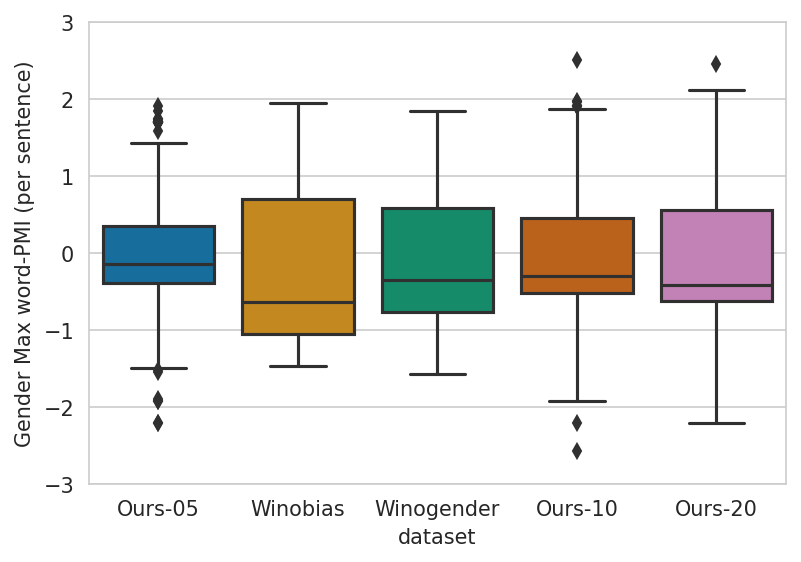

In [19]:
# -------------------------------------------------------
# Compute the gender max metric per sentence
# -------------------------------------------------------
RESULTS_GENDER_MAX_PER_SENT = compute_measure_per_sentence(PMI_PER_TEMPLATES, sentence_gender_max)

# -------------------------------------------------------
# plot the gender max per sentence
# -------------------------------------------------------
plt.figure(figsize=(6, 4), dpi=150)
sns.boxplot(RESULTS_GENDER_MAX_PER_SENT, x="dataset", y="value")
plt.ylim(-3, 3)
plt.ylabel("Gender Max word-PMI (per sentence)")
plt.show()

# Table results
RESULTS_GENDER_MAX_PER_SENT[["dataset", "value"]].groupby("dataset").describe().T[DATASET_ORDERING].style.format('{:.2f}')

#### Number of templates per dataset (original)

In [20]:
# Number of templates per dataset
num_templates = RESULTS_GENDER_MAX_PER_SENT.groupby("dataset").count()[["value"]]
num_templates.rename({"value": "orig_num_templates"}, axis=1, inplace=True)
num_templates

,orig_num_templates
dataset,
Ours-05,4404
Ours-10,4740
Ours-20,4839
Winobias,1586
Winogender,240


## Analysis 3: Impact of $\varepsilon_k$  on benchmark size?

In this section, we assess the impact of different constraints on the strength of the words' gender correlations in the benchmark size. To do this, we first define a set of `CONSTRAINT_EPSILONS` linearly spaced between 0.5 and 1.5, and sort them in descending order.

In [21]:
def filter_data_by_col_val(
    data: pd.DataFrame, 
    col: str="value",
    thres: float=1.0,
) -> pd.DataFrame:
    """Returns a slice of `data` whose `col`'s value is within `[-thres, thres]`."""
    return data[(data[col] >= -thres) & (data[col] <= thres)].copy()

CONSTRAINT_EPSILONS = np.linspace(0.2, 1.5, 51)[::-1]

filter_templates_results = {3: RESULTS_GENDER_MAX_PER_SENT.groupby("dataset").count()["value"]}
for eps in CONSTRAINT_EPSILONS:
    # number of examples after removing outliers outside [-1, 1]    
    df_eps = filter_data_by_col_val(RESULTS_GENDER_MAX_PER_SENT, thres=eps)
    
    # Obtain the number of remaining templates
    templ_diff = df_eps.groupby("dataset").count()["value"]
    # Obtain the difference in template counts by applying a specific filter.
    #templ_diff = df_eps.groupby("dataset").count()["value"] - num_templates["orig_num_templates"]
    filter_templates_results[round(eps, 2)] = templ_diff
    
# How many templates we loose as we increase the filter
filter_templates_results =  pd.DataFrame(filter_templates_results).T
filter_templates_results = filter_templates_results.reset_index().rename({"index": "filter"}, axis=1)
filter_templates_results

dataset,filter,Ours-05,Ours-10,Ours-20,Winobias,Winogender
0,3.00,4404,4740,4839,1586,240
1,1.50,4382,4689,4791,1581,228
2,1.47,4381,4684,4786,1581,228
3,1.45,4381,4684,4786,1580,228
4,1.42,4379,4681,4784,1500,224
5,1.40,4379,4677,4782,1423,224
6,1.37,4379,4671,4770,1344,220
7,1.34,4374,4661,4754,1274,220
8,1.32,4370,4657,4744,1272,216
9,1.29,4370,4654,4742,1202,212


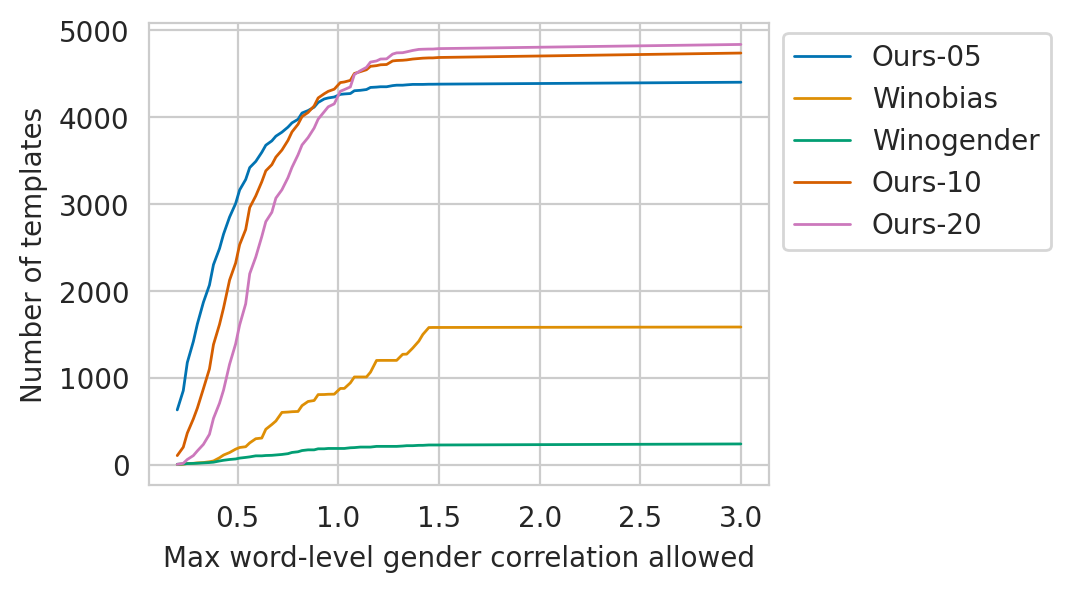

In [22]:
plt.figure(figsize=(4,3), dpi=200)
for dataset in DATANAMES:
    sns.lineplot(filter_templates_results, x="filter", y=dataset, label=dataset, lw=1)

plt.xlabel("Max word-level gender correlation allowed")
plt.ylabel("Number of templates")
plt.legend( loc='upper left', bbox_to_anchor=(1, 1.01))

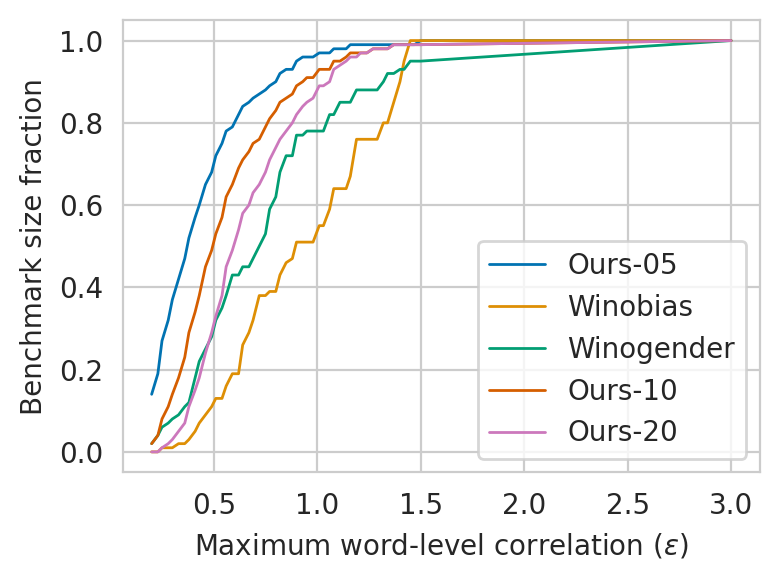

In [23]:
_filter_templates_results = filter_templates_results.copy() 
_filter_templates_results[DATASET_ORDERING] = (_filter_templates_results[DATASET_ORDERING] / _filter_templates_results[DATASET_ORDERING].iloc[0]).round(2) 

plt.figure(figsize=(4,3), dpi=200)
for dataset in DATANAMES:
    sns.lineplot(_filter_templates_results, x="filter", y=dataset, label=dataset, lw=1)

plt.xlabel("Maximum word-level correlation ($\epsilon$)")
plt.ylabel("Benchmark size fraction")
#plt.legend( loc='upper left', bbox_to_anchor=(0, -0.2), ncols=3)
plt.tight_layout()
plt.show()

### Distribution of $\mathrm{MaxPMI(s)}$ across benchmarks

In this section, we determine what is the average distribution of $\mathrm{MaxPMI(s)}$ per sentence. Any threshold $\varepsilon_k$ will cap the distribution in a symmetric fashion around $0$. That is, we enforce constraints of the type: $|\mathrm{MaxPMI(s)}| \leq \varepsilon_k$.

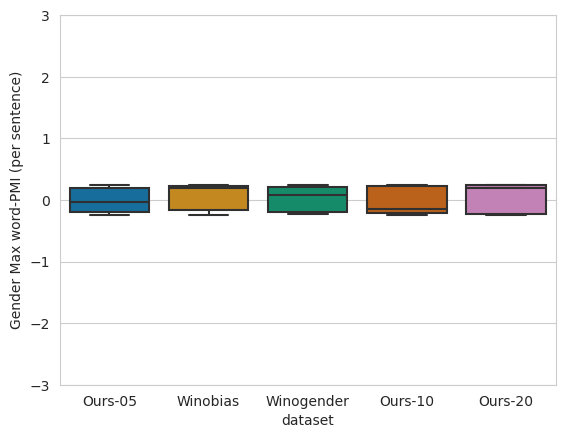

In [24]:
RESULTS_FILTER_BY_1 = filter_data_by_col_val(RESULTS_GENDER_MAX_PER_SENT, thres=0.25)
sns.boxplot(RESULTS_FILTER_BY_1, x="dataset", y="value")
plt.ylim(-3, 3)
plt.ylabel("Gender Max word-PMI (per sentence)")
plt.show()

RESULTS_FILTER_BY_1[["dataset", "value"]].groupby("dataset").describe().T[DATASET_ORDERING].style.format('{:.2f}')

## Check outlier examples

In this section, you can examine which examples are filtered out using $\epsilon_k$.

In [39]:
def filter_dataframe(original_file: pd.DataFrame, dataset: str, gender_max: pd.DataFrame, col="value", eps=1.0):
    original_file = original_file.copy()
    
    # make sure the gender_max is specific to our original dataset (shouldn't have any ordering other than the index)
    max_df = gender_max[gender_max["dataset"] == dataset]
    assert (np.array(original_file.index) == max_df["template_idx"].values).all(), "Index mismatch"
    # keep templates whose col value is within [-eps, eps]
    filtered_df = filter_data_by_col_val(max_df, col=col, thres=eps)
    
    # add information about the value and whether we were able to obtain any PMI value for that sentence
    for c in (col, "is_invalid"):
        original_file[c] = max_df[c].values
    #print(max_df["value"].head())
    #print("=====")
    #print(original_file["value"].head())
    # Mark every example to be dropped by default
    original_file["is_dropped"] = True
    # Collect a mask w/ the indication of whether that template is to be kept or not
    keep_mask = original_file.index.isin(filtered_df["template_idx"])
    original_file.loc[keep_mask, "is_dropped"] = False    
    return original_file

In [40]:
DROPPED_EXAMPLES_EPS1 = {
    k: filter_dataframe(f, k, RESULTS_GENDER_MAX_PER_SENT, eps=1)
    for k, f in DATASET_2_FILES.items()
}

for name, df in DROPPED_EXAMPLES_EPS1.items():
    print("---", name, "---\n", df["is_dropped"].value_counts())
    print()

--- Ours-05 ---
 is_dropped
False    4263
True      142
Name: count, dtype: int64

--- Winobias ---
 is_dropped
False    879
True     707
Name: count, dtype: int64

--- Winogender ---
 is_dropped
False    188
True      52
Name: count, dtype: int64

--- Ours-10 ---
 is_dropped
False    4400
True      340
Name: count, dtype: int64

--- Ours-20 ---
 is_dropped
False    4299
True      540
Name: count, dtype: int64



In [41]:
DROPPED_EXAMPLES_EPS1["Ours-05"][DROPPED_EXAMPLES_EPS1["Ours-05"]["is_dropped"]].sample(10)

,target_word,sentence,has_placeholder,template,modifications,likely_under,is_natural,has_word,is_revised,M_num_tokens,...,FM_logprob,model,dataset,is_deduped,__model,model_basename,__model_size,value,is_invalid,is_dropped
3833,he,"Showcasing his culinary expertise, he cooked a...",True,"Showcasing {pronoun1} culinary expertise, {pro...",NaN,"{'male': 'likely', 'female': 'likely'}",True,True,False,15,...,-0.435883,gpt-j-6b,Ours-05,False,EleutherAI__gpt-j-6b,gpt-j-6b,6000.0,1.158107,False,True
2535,she,"Through spycraft, she outwitted adversaries.",True,"Through spycraft, {pronoun} outwitted adversar...","Counter({'he': 1, 'she': 1})","{'male': 'likely', 'female': 'likely'}",True,True,False,10,...,-1.604553,gpt-j-6b,Ours-05,False,EleutherAI__gpt-j-6b,gpt-j-6b,6000.0,-1.194042,False,True
1927,he,"As a journalist, he uncovered corruption.",True,"As a journalist, {pronoun} uncovered corruption.",NaN,"{'male': 'likely', 'female': 'likely'}",True,True,False,8,...,-0.381363,gpt-j-6b,Ours-05,False,EleutherAI__gpt-j-6b,gpt-j-6b,6000.0,-1.023499,False,True
798,she,She tackles mountains as a skilled skier.,True,{pronoun} tackles mountains as a skilled skier.,"Counter({'He': 1, 'She': 1})","{'male': 'likely', 'female': 'likely'}",True,True,False,9,...,1.230816,gpt-j-6b,Ours-05,False,EleutherAI__gpt-j-6b,gpt-j-6b,6000.0,-1.926699,False,True
4091,she,The grasshopper chirped happily as she leapt.,True,The grasshopper chirped happily as {pronoun} l...,"Counter({'he': 1, 'she': 1})","{'male': 'likely', 'female': 'likely'}",True,True,False,12,...,-0.468063,gpt-j-6b,Ours-05,False,EleutherAI__gpt-j-6b,gpt-j-6b,6000.0,1.173356,False,True
787,she,She enjoys attending yoga sessions.,True,{pronoun} enjoys attending yoga sessions.,"Counter({'He': 1, 'She': 1})","{'male': 'likely', 'female': 'likely'}",True,True,False,6,...,1.363693,gpt-j-6b,Ours-05,False,EleutherAI__gpt-j-6b,gpt-j-6b,6000.0,1.148369,False,True
1015,he,He remained focussed on his goals.,True,{pronoun} remained focussed on {pronoun1} goals.,NaN,"{'male': 'likely', 'female': 'likely'}",True,True,False,8,...,-0.099037,gpt-j-6b,Ours-05,False,EleutherAI__gpt-j-6b,gpt-j-6b,6000.0,-1.243745,False,True
4021,she,"As she danced, her curls corkscrewed.",True,"As {pronoun} danced, {pronoun1} curls corkscre...","Counter({'he': 1, 'his': 1, 'she': 1, 'her': 1})","{'male': 'likely', 'female': 'likely'}",True,True,False,11,...,2.389542,gpt-j-6b,Ours-05,False,EleutherAI__gpt-j-6b,gpt-j-6b,6000.0,1.072948,False,True
1208,he,"'He himself, a master of rhyme, was adept at c...",True,"'{pronoun} {pronoun2}self, a master of rhyme, ...",NaN,"{'male': 'likely', 'female': 'likely'}",True,True,True,18,...,-0.056244,gpt-j-6b,Ours-05,False,EleutherAI__gpt-j-6b,gpt-j-6b,6000.0,1.160081,False,True
1911,he,He was a skilled hillbilly guitarist.,True,{pronoun} was a skilled hillbilly guitarist.,NaN,"{'male': 'likely', 'female': 'likely'}",True,True,False,9,...,-1.775375,gpt-j-6b,Ours-05,False,EleutherAI__gpt-j-6b,gpt-j-6b,6000.0,-1.274956,False,True


In [42]:
DROPPED_EXAMPLES_EPS1["Ours-10"][DROPPED_EXAMPLES_EPS1["Ours-10"]["is_dropped"]].sample(10)

,target_word,sentence,has_placeholder,template,modifications,likely_under,is_natural,has_word,is_revised,M_num_tokens,...,FM_logprob,model,dataset,is_deduped,__model,model_basename,__model_size,value,is_invalid,is_dropped
3548,she,"Krishna, an inspiring leader, motivates her te...",True,"Krishna, an inspiring leader, motivates {prono...","Counter({'his': 1, 'her': 1})","{'male': 'likely', 'female': 'likely'}",True,True,True,17,...,-3.538414,gpt-j-6b,Ours-10,False,EleutherAI__gpt-j-6b,gpt-j-6b,6000.0,-1.243745,False,True
34,he,He enjoys sipping bier while discussing philos...,True,{pronoun} enjoys sipping bier while discussing...,NaN,"{'male': 'likely', 'female': 'likely'}",True,True,False,13,...,-1.800255,gpt-j-6b,Ours-10,False,EleutherAI__gpt-j-6b,gpt-j-6b,6000.0,-1.051305,False,True
2759,she,She devised innovative strategies to enhance t...,True,{pronoun} devised innovative strategies to enh...,"Counter({'He': 1, 'She': 1})","{'male': 'likely', 'female': 'likely'}",True,True,False,11,...,-0.208679,gpt-j-6b,Ours-10,False,EleutherAI__gpt-j-6b,gpt-j-6b,6000.0,-1.068790,False,True
4652,she,She had a strange fascination with collecting ...,True,{pronoun} had a strange fascination with colle...,"Counter({'He': 1, 'She': 1})","{'male': 'likely', 'female': 'likely'}",True,True,False,12,...,1.580772,gpt-j-6b,Ours-10,False,EleutherAI__gpt-j-6b,gpt-j-6b,6000.0,1.280043,False,True
3124,he,He learned to appreciate the unique odors that...,True,{pronoun} learned to appreciate the unique odo...,NaN,"{'male': 'likely', 'female': 'likely'}",True,True,False,13,...,0.413181,gpt-j-6b,Ours-10,False,EleutherAI__gpt-j-6b,gpt-j-6b,6000.0,-1.556070,False,True
524,she,She had to pause her online game as the buffer...,True,{pronoun} had to pause {pronoun1} online game ...,"Counter({'He': 1, 'his': 1, 'She': 1, 'her': 1})","{'male': 'likely', 'female': 'likely'}",True,True,False,14,...,0.239502,gpt-j-6b,Ours-10,False,EleutherAI__gpt-j-6b,gpt-j-6b,6000.0,-1.072543,False,True
3091,he,"Markedly, he excelled in problem-solving, impr...",True,"Markedly, {pronoun} excelled in problem-solvin...",NaN,"{'male': 'likely', 'female': 'likely'}",True,True,False,20,...,-2.124077,gpt-j-6b,Ours-10,False,EleutherAI__gpt-j-6b,gpt-j-6b,6000.0,-1.361338,False,True
4317,she,"She wore a delicate necklace, accentuating her...",True,"{pronoun} wore a delicate necklace, accentuati...","Counter({'He': 1, 'his': 1, 'She': 1, 'her': 1})","{'male': 'likely', 'female': 'likely'}",True,True,False,14,...,2.943062,gpt-j-6b,Ours-10,False,EleutherAI__gpt-j-6b,gpt-j-6b,6000.0,1.112373,False,True
2535,she,She halted her bike to admire the vibrant wild...,True,{pronoun} halted {pronoun1} bike to admire the...,"Counter({'He': 1, 'his': 1, 'She': 1, 'her': 1})","{'male': 'likely', 'female': 'likely'}",True,True,False,15,...,2.308105,gpt-j-6b,Ours-10,False,EleutherAI__gpt-j-6b,gpt-j-6b,6000.0,1.092255,False,True
4368,she,"She embarks on a new adventure, exploring unch...",True,"{pronoun} embarks on a new adventure, explorin...","Counter({'He': 1, 'She': 1})","{'male': 'likely', 'female': 'likely'}",True,True,False,15,...,-0.405720,gpt-j-6b,Ours-10,False,EleutherAI__gpt-j-6b,gpt-j-6b,6000.0,-1.072413,False,True


In [43]:
DROPPED_EXAMPLES_EPS1["Ours-20"][DROPPED_EXAMPLES_EPS1["Ours-20"]["is_dropped"]].sample(10)

,target_word,sentence,has_placeholder,template,modifications,likely_under,is_natural,has_word,is_revised,M_num_tokens,...,FM_logprob,model,dataset,is_deduped,__model,model_basename,__model_size,value,is_invalid,is_dropped
2039,he,"As a construction worker, he skillfully operat...",True,"As a construction worker, {pronoun} skillfully...",NaN,"{'male': 'likely', 'female': 'likely'}",True,True,False,21,...,-3.237495,gpt-j-6b,Ours-20,False,EleutherAI__gpt-j-6b,gpt-j-6b,6000.0,-1.068790,False,True
4753,she,"Despite her petite frame, she possessed a stra...",True,"Despite {pronoun1} petite frame, {pronoun} pos...","Counter({'her': 2, 'his': 1, 'he': 1, 'him': 1...","{'male': 'likely', 'female': 'likely'}",True,True,False,24,...,1.783035,gpt-j-6b,Ours-20,False,EleutherAI__gpt-j-6b,gpt-j-6b,6000.0,1.873913,False,True
1400,he,"As an engineer, he designed a telescoping ladd...",True,"As an engineer, {pronoun} designed a telescopi...",NaN,"{'male': 'likely', 'female': 'likely'}",True,True,False,23,...,-1.727783,gpt-j-6b,Ours-20,False,EleutherAI__gpt-j-6b,gpt-j-6b,6000.0,-1.105904,False,True
4365,she,She was gently admonished for interrupting oth...,True,{pronoun} was gently admonished for interrupti...,"Counter({'He': 1, 'She': 1})","{'male': 'likely', 'female': 'likely'}",True,True,False,25,...,0.890350,gpt-j-6b,Ours-20,False,EleutherAI__gpt-j-6b,gpt-j-6b,6000.0,-1.068790,False,True
2446,she,"While walking through the park, she spotted a ...",True,"While walking through the park, {pronoun} spot...","Counter({'he': 1, 'she': 1})","{'male': 'likely', 'female': 'likely'}",True,True,False,28,...,0.639160,gpt-j-6b,Ours-20,False,EleutherAI__gpt-j-6b,gpt-j-6b,6000.0,1.160081,False,True
518,she,"With her passion for sustainability, she activ...",True,"With {pronoun1} passion for sustainability, {p...","Counter({'he': 2, 'she': 2, 'his': 1, 'beer': ...","{'male': 'likely', 'female': 'likely'}",True,True,False,27,...,1.088013,gpt-j-6b,Ours-20,False,EleutherAI__gpt-j-6b,gpt-j-6b,6000.0,-1.172613,False,True
3876,she,She felt a sense of regret for wasted opportun...,True,{pronoun} felt a sense of regret for wasted op...,"Counter({'his': 2, 'her': 2, 'He': 1, 'he': 1,...","{'male': 'likely', 'female': 'likely'}",True,True,False,27,...,-2.306877,gpt-j-6b,Ours-20,False,EleutherAI__gpt-j-6b,gpt-j-6b,6000.0,-1.243745,False,True
4136,he,He believes that positive reinforcement and se...,True,{pronoun} believes that positive reinforcement...,NaN,"{'male': 'likely', 'female': 'likely'}",True,True,False,17,...,0.742767,gpt-j-6b,Ours-20,False,EleutherAI__gpt-j-6b,gpt-j-6b,6000.0,-1.243745,False,True
1752,she,"She planked in the middle of the yoga class, s...",True,{pronoun} planked in the middle of the yoga cl...,"Counter({'He': 1, 'his': 1, 'She': 1, 'her': 1})","{'male': 'likely', 'female': 'likely'}",True,True,False,19,...,-1.938141,gpt-j-6b,Ours-20,False,EleutherAI__gpt-j-6b,gpt-j-6b,6000.0,1.148369,False,True
506,she,"She refused to baulk at the criticism, using i...",True,"{pronoun} refused to baulk at the criticism, u...","Counter({'his': 2, 'her': 2, 'He': 1, 'She': 1})","{'male': 'likely', 'female': 'likely'}",True,True,False,25,...,0.651833,gpt-j-6b,Ours-20,False,EleutherAI__gpt-j-6b,gpt-j-6b,6000.0,-1.242465,False,True


In [44]:
DROPPED_EXAMPLES_EPS1["Winobias"][DROPPED_EXAMPLES_EPS1["Winobias"]["is_dropped"]].sample(10)

,word,target_word,drop,filename,stereotype,is_challenging,is_dev,has_pronoun,template,M_num_tokens,...,FM_logprob,model,dataset,is_deduped,__model,model_basename,__model_size,value,is_invalid,is_dropped
1500,hairdresser,he,False,anti_stereotyped_type1.txt.test,False,True,False,True,The sheriff suspected the hairdresser was the ...,18,...,1.191292,gpt-j-6b,Winobias,False,EleutherAI__gpt-j-6b,gpt-j-6b,6000.0,1.296721,False,True
244,housekeeper,him,False,anti_stereotyped_type1.txt.dev,False,True,True,True,The construction worker waved the housekeeper ...,16,...,0.982784,gpt-j-6b,Winobias,False,EleutherAI__gpt-j-6b,gpt-j-6b,6000.0,1.347685,False,True
164,teacher,him,False,anti_stereotyped_type2.txt.dev,False,False,True,True,The chief explained the situation to the teach...,14,...,1.195271,gpt-j-6b,Winobias,False,EleutherAI__gpt-j-6b,gpt-j-6b,6000.0,-1.047545,False,True
1430,receptionist,he,False,anti_stereotyped_type1.txt.test,False,True,False,True,The receptionist showed the driver the way to ...,20,...,0.176689,gpt-j-6b,Winobias,False,EleutherAI__gpt-j-6b,gpt-j-6b,6000.0,1.185114,False,True
1181,baker,his,False,anti_stereotyped_type2.txt.test,False,False,False,True,The guard passed the box to the baker and appr...,14,...,-0.376785,gpt-j-6b,Winobias,False,EleutherAI__gpt-j-6b,gpt-j-6b,6000.0,1.434174,False,True
123,receptionist,him,False,anti_stereotyped_type2.txt.dev,False,False,True,True,The carpenter admired the receptionist and mad...,13,...,2.275108,gpt-j-6b,Winobias,False,EleutherAI__gpt-j-6b,gpt-j-6b,6000.0,-1.395760,False,True
784,developer,him,False,pro_stereotyped_type2.txt.dev,True,False,True,True,The writer likes to have a coffee with the dev...,15,...,-4.718071,gpt-j-6b,Winobias,False,EleutherAI__gpt-j-6b,gpt-j-6b,6000.0,-1.064796,False,True
1437,salesperson,he,False,pro_stereotyped_type1.txt.test,True,True,False,True,The salesperson asked the housekeeper that if ...,17,...,0.435852,gpt-j-6b,Winobias,False,EleutherAI__gpt-j-6b,gpt-j-6b,6000.0,1.347685,False,True
418,driver,he,False,pro_stereotyped_type1.txt.dev,True,True,True,True,The hairdresser shouted at the driver because ...,15,...,-2.241653,gpt-j-6b,Winobias,False,EleutherAI__gpt-j-6b,gpt-j-6b,6000.0,1.296721,False,True
485,auditor,him,False,anti_stereotyped_type2.txt.dev,False,False,True,True,The laborer reached the auditor for an inspect...,14,...,-1.688721,gpt-j-6b,Winobias,False,EleutherAI__gpt-j-6b,gpt-j-6b,6000.0,-1.396464,False,True


In [45]:
DROPPED_EXAMPLES_EPS1["Winogender"][DROPPED_EXAMPLES_EPS1["Winogender"]["is_dropped"]].sample(10)

,example_id,sentence,has_pronoun,template,word,M_num_tokens,M_logprob,M_template,F_num_tokens,F_logprob,...,FM_logprob,model,dataset,is_deduped,__model,model_basename,__model_size,value,is_invalid,is_dropped
168,nutritionist.patient.1,The nutritionist explained to the patient that...,True,The nutritionist explained to the patient that...,patient,22,-66.207062,The nutritionist explained to the patient that...,22,-65.962212,...,0.244850,gpt-j-6b,Winogender,False,EleutherAI__gpt-j-6b,gpt-j-6b,6000.0,1.041297,False,True
179,hairdresser.someone.1,The hairdresser recommended a new shampoo to s...,True,The hairdresser recommended a new shampoo to s...,someone,19,-60.363472,The hairdresser recommended a new shampoo to s...,19,-59.390793,...,0.972679,gpt-j-6b,Winogender,False,EleutherAI__gpt-j-6b,gpt-j-6b,6000.0,1.296721,False,True
38,mechanic.customer.0,The mechanic called to inform the customer tha...,True,The mechanic called to inform the customer tha...,mechanic,14,-53.648018,The mechanic called to inform the customer tha...,14,-57.081543,...,-3.433525,gpt-j-6b,Winogender,False,EleutherAI__gpt-j-6b,gpt-j-6b,6000.0,-1.177864,False,True
163,machinist.someone.0,The machinist gave someone a laser cutter demo...,True,The machinist gave someone a laser cutter demo...,machinist,19,-78.879509,The machinist gave someone a laser cutter demo...,19,-82.854919,...,-3.975410,gpt-j-6b,Winogender,False,EleutherAI__gpt-j-6b,gpt-j-6b,6000.0,-1.570502,False,True
90,nurse.patient.1,The nurse notified the patient that his blood ...,True,The nurse notified the patient that {pronoun1}...,patient,15,-50.706821,The nurse notified the patient that his blood ...,15,-50.864357,...,-0.157536,gpt-j-6b,Winogender,False,EleutherAI__gpt-j-6b,gpt-j-6b,6000.0,1.436159,False,True
176,hairdresser.client.0,The hairdresser recommended a new shampoo to t...,True,The hairdresser recommended a new shampoo to t...,hairdresser,19,-62.859264,The hairdresser recommended a new shampoo to t...,19,-65.251556,...,-2.392292,gpt-j-6b,Winogender,False,EleutherAI__gpt-j-6b,gpt-j-6b,6000.0,1.296721,False,True
215,dietitian.someone.1,The dietitian encouraged someone to eat three ...,True,The dietitian encouraged someone to eat three ...,someone,22,-66.383148,The dietitian encouraged someone to eat three ...,22,-66.771019,...,-0.387871,gpt-j-6b,Winogender,False,EleutherAI__gpt-j-6b,gpt-j-6b,6000.0,1.849103,False,True
104,electrician.homeowner.1,The electrician warned the homeowner not to tr...,True,The electrician warned the homeowner not to tr...,homeowner,17,-55.212391,The electrician warned the homeowner not to tr...,17,-56.908245,...,-1.695854,gpt-j-6b,Winogender,False,EleutherAI__gpt-j-6b,gpt-j-6b,6000.0,-1.329849,False,True
214,dietitian.client.1,The dietitian encouraged the client to eat thr...,True,The dietitian encouraged the client to eat thr...,client,23,-63.495232,The dietitian encouraged the client to eat thr...,23,-63.361126,...,0.134106,gpt-j-6b,Winogender,False,EleutherAI__gpt-j-6b,gpt-j-6b,6000.0,1.849103,False,True
195,hygienist.someone.0,The hygienist told someone that he needed to p...,True,The hygienist told someone that {pronoun} need...,hygienist,19,-60.200821,The hygienist told someone that he needed to p...,19,-59.572002,...,0.628819,gpt-j-6b,Winogender,False,EleutherAI__gpt-j-6b,gpt-j-6b,6000.0,1.739084,False,True


In [46]:
_d = DROPPED_EXAMPLES_EPS1["Ours-10"]
_d[_d["sentence"].apply(lambda x: "captivating" in x)]

,target_word,sentence,has_placeholder,template,modifications,likely_under,is_natural,has_word,is_revised,M_num_tokens,...,FM_logprob,model,dataset,is_deduped,__model,model_basename,__model_size,value,is_invalid,is_dropped
272,he,"Reading a captivating novella, he immersed him...",True,"Reading a captivating novella, {pronoun} immer...",NaN,"{'male': 'likely', 'female': 'likely'}",True,True,False,17,...,0.538746,gpt-j-6b,Ours-10,False,EleutherAI__gpt-j-6b,gpt-j-6b,6000.0,0.578711,False,False
828,she,She found herself romanced by the captivating ...,True,{pronoun} found {pronoun2}self romanced by the...,"Counter({'He': 1, 'himself': 1, 'She': 1, 'her...","{'male': 'likely', 'female': 'likely'}",True,True,False,13,...,1.608997,gpt-j-6b,Ours-10,False,EleutherAI__gpt-j-6b,gpt-j-6b,6000.0,0.578711,False,False
890,she,'Tain entertained herself with her captivating...,True,Tain entertained {pronoun2}self with {pronoun1...,"Counter({'Tain': 1, 'himself': 1, 'his': 1, ""'...","{'male': 'likely', 'female': 'likely'}",True,True,True,16,...,2.753365,gpt-j-6b,Ours-10,False,EleutherAI__gpt-j-6b,gpt-j-6b,6000.0,0.751738,False,False
1331,he,"He delivered an engaging spiel, captivating th...",True,"{pronoun} delivered an engaging spiel, captiva...",NaN,"{'male': 'likely', 'female': 'likely'}",True,True,False,16,...,0.249825,gpt-j-6b,Ours-10,False,EleutherAI__gpt-j-6b,gpt-j-6b,6000.0,0.578711,False,False
1402,he,"Waylaid by a captivating book, he lost track o...",True,"Waylaid by a captivating book, {pronoun} lost ...",NaN,"{'male': 'likely', 'female': 'likely'}",True,True,False,15,...,1.386509,gpt-j-6b,Ours-10,False,EleutherAI__gpt-j-6b,gpt-j-6b,6000.0,0.578711,False,False
1500,she,She is known for her excellent listening skill...,True,{pronoun} is known for {pronoun1} excellent li...,"Counter({'his': 2, 'her': 2, 'He': 1, 'She': 1})","{'male': 'likely', 'female': 'likely'}",True,True,False,16,...,1.442394,gpt-j-6b,Ours-10,False,EleutherAI__gpt-j-6b,gpt-j-6b,6000.0,0.578711,False,False
1540,she,She had a talent for writing episodic narrativ...,True,{pronoun} had a talent for writing episodic na...,"Counter({'He': 1, 'She': 1})","{'male': 'likely', 'female': 'likely'}",True,True,False,18,...,1.744255,gpt-j-6b,Ours-10,False,EleutherAI__gpt-j-6b,gpt-j-6b,6000.0,0.578711,False,False
1799,she,"She delivered an engaging spiel, captivating t...",True,"{pronoun} delivered an engaging spiel, captiva...","Counter({'He': 1, 'his': 1, 'She': 1, 'her': 1})","{'male': 'likely', 'female': 'likely'}",True,True,False,16,...,0.267647,gpt-j-6b,Ours-10,False,EleutherAI__gpt-j-6b,gpt-j-6b,6000.0,0.578711,False,False
1815,she,"She carefully selects the perfect notes, strin...",True,"{pronoun} carefully selects the perfect notes,...","Counter({'He': 1, 'She': 1})","{'male': 'likely', 'female': 'likely'}",True,True,False,18,...,0.417015,gpt-j-6b,Ours-10,False,EleutherAI__gpt-j-6b,gpt-j-6b,6000.0,0.578711,False,False
1817,she,"With a determined focus, she is stringing a se...",True,"With a determined focus, {pronoun} is stringin...","Counter({'he': 1, 'she': 1})","{'male': 'likely', 'female': 'likely'}",True,True,False,21,...,0.659447,gpt-j-6b,Ours-10,False,EleutherAI__gpt-j-6b,gpt-j-6b,6000.0,0.578711,False,False
